2000
parametric: 0.051
naive: 0.374
ks: 0.597


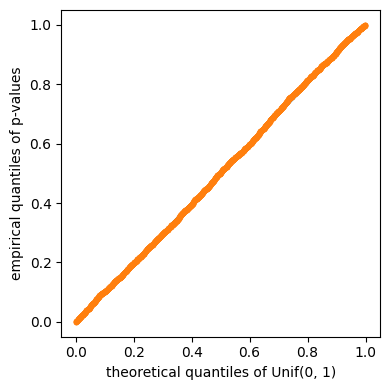

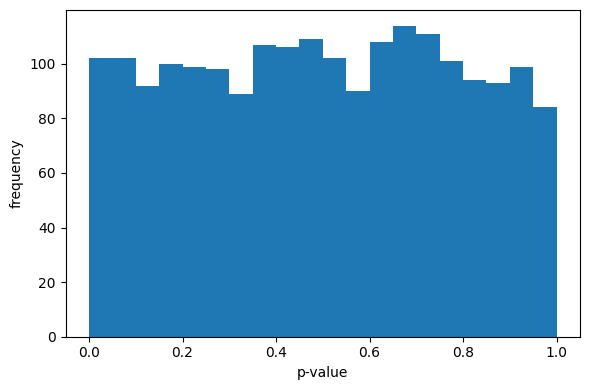

In [5]:
from scipy.stats import norm
from scipy.stats import kstest
from sicore import pvalues_qqplot, pvalues_hist
import os
import pickle
import numpy as np

n, p, beta = 150, 20, 0.0
option = 2

results = []
dir_name = f'results_op{option}'
for file in os.listdir(dir_name):
    if f'n{n}p{p}beta{beta}' in file:
        with open(os.path.join(dir_name, file), 'rb') as f:
            result = pickle.load(f)
            results += result

print(len(results))
p_list = np.array([result.p_value for result in results])
naive_p_list = np.array([2 * norm.cdf(-np.abs(result.stat)) for result in results])

print(f"parametric: {np.mean(p_list < 0.05):.3f}")
print(f"naive: {np.mean(naive_p_list < 0.05):.3f}")
print(f'ks: {kstest(p_list, "uniform")[1]:.3f}')

pvalues_qqplot(p_list)
pvalues_hist(p_list)


In [ ]:
# check of working

from source.missing_imputation import definite_regression_imputation
import numpy as np
from source.base_component import extract_features, remove_outliers, intersection, union
from source.outlier_detection import cook_distance, dffits
from source.feature_selection import stepwise_feature_selection, lasso, marginal_screening
from source.pipeline import make_pipeline, make_dataset

from temp.feature_selection_si import sfs_si, lasso_si, ms_si
from temp.outlier_removal_si import cook_si, dffits_si

n, p = 100, 10
rng = np.random.default_rng()

X = rng.normal(size=(n, p))

def option():
    X, y = make_dataset()
    y = definite_regression_imputation(X, y)

    M = marginal_screening(X, y, 5)
    X = extract_features(X, M)

    O = dffits(X, y, 3.0)
    X, y = remove_outliers(X, y, O)

    M1 = stepwise_feature_selection(X, y, 3)
    M2 = lasso(X, y, 0.08)
    M = intersection(M1, M2)
    return make_pipeline(output=M)

pipeline = option()

a = rng.normal(size=n)
b = rng.normal(size=n)
z = rng.uniform(-2, 2)
pipeline.X = X
pipeline.reset_intervals()
MO, lu = pipeline.algorithm(a, b, z)
print(*lu)

l, u = -np.inf, np.inf
M, O = list(range(p)), []
M, O, l, u = ms_si(a, b, z, X, M, O, l, u, 5)
M, O, l, u = dffits_si(a, b, z, X, M, O, l, u, 3.0)
M1, O, l, u = sfs_si(a, b, z, X, M, O, l, u, 3)
M2, O, l, u = lasso_si(a, b, z, X, M, O, l, u, 0.08)
print(l, u)